In [ ]:
> Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста,
проверяя метрику качества FPR (будем проверять на конверсии в покупку). 
Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины,
если сплит-система действительно сломана

Описание колонок
experimentVariant – вариант эксперимента
version – версия приложения
purchase – факт покупки

Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа!
Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

💡 Ответ: как найти причины поломки?

In [45]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [46]:
df = pd.read_csv('/home/jupyter-k-samojlovich-17/Statistic/Lesson_10/Stat_10_Project/hw_aa.csv', sep=';')
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [47]:
# выполняем проверку данных

In [48]:
df.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [49]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [50]:
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

In [51]:
df.purchase.unique()

array([0, 1])

In [52]:
# Делим исходные данные на 2 группы
df_exp_0 = df.query('experimentVariant == 0').purchase # данные по варианту эксперимента "0"
df_exp_1 = df.query('experimentVariant == 1').purchase # данные по варианту эксперимента "1"

In [53]:
# ПРОВОДИМ А/А ТЕСТ

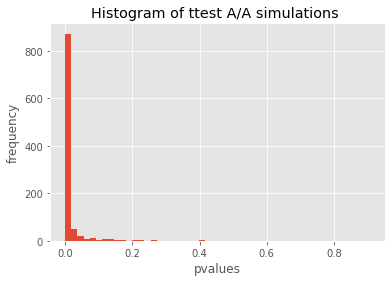

Прцент ложноположительных случаев, не превышающих 0.05 =  93.89999999999999 %


In [54]:
n = 100000 # размер оригинальной выборке
simulations = 1000 # количество симуляций (подвыборок)
n_s = 1000 # размер подвыборки
res = [] # результаты тестов (pvalue)

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_exp_0.sample(n_s, replace = False).values
    s2 = df_exp_1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('Прцент ложноположительных случаев, не превышающих 0.05 = ', sum(np.array(res) <0.05) / simulations * 100, '%')

In [55]:
# Процент ложноположительных случаев значительно больше 5% => надо искать поломку сплит-системы

In [56]:
# конверсия в зависимости от варианта эксперимента
conv_expeiment = df.groupby('experimentVariant', as_index=False).agg({'purchase': 'mean'})
conv_expeiment

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


In [57]:
# конверсия в зависимости от варианта эксперимента и версии приложения
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


In [58]:
# ВИДНО, ЧТО НА ВЕРСИИ v2.8.0 НАБЛЮДАЕТСЯ ЗНАЧИТЕЛЬНАЯ ПРОСАДКА ПО СРАВНЕНИЮ С ДРУГИМИ ВЕРСИЯМИ !!!
# ЗНАЧИТ, АНОМАЛИЮ НАДО ИСКАТЬ В ДАННЫХ ПО ВЕРСИИ v2.8.0

In [59]:
# конверсия в зависимости от версии приложения
df.groupby('version', as_index=False).agg({'purchase': 'mean'})

,version,purchase
0,v2.8.0,0.023372
1,v2.9.0,0.072973
2,v3.7.4.0,0.061484
3,v3.8.0.0,0.060319


In [60]:
# ПРИЧИНА ПОЛОМКИ СИСТЕМЫ ЗАКЛЮЧАЕТСЯ В ДАННЫХ ПО ВЕРСИИ v2.8.0
# ИСКЛЮЧИМ ЭТИ ДАННЫЕ ИЗ ДАТАФРЕЙМА

In [61]:
df_new = df.query('version != "v2.8.0"') # ИСХОДНЫЕ ДАННЫЕ БЕЗ ВЕРСИИ v2.8.0

In [68]:
df_new_exp_0 = df_new.query('experimentVariant == 0').purchase # данные по варианту эксперимента "0" без версии v2.8.0
df_new_exp_1 = df_new.query('experimentVariant == 1').purchase # данные по варианту эксперимента "1" без версии v2.8.0

In [69]:
# ПОВТОРЯЕМ А/А ТЕСТ

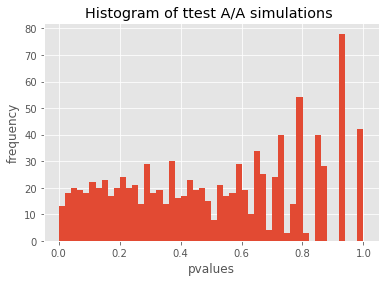

Прцент ложноположительных случаев, не превышающих 0.05 =  3.8 %


In [70]:
n = 100000 # размер оригинальной выборке
simulations = 1000 # количество симуляций (подвыборок)
n_s = 1000 # размер подвыборки
res_new = [] # результаты тестов (pvalue)

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_new_exp_0.sample(n_s, replace = False).values
    s2 = df_new_exp_1.sample(n_s, replace = False).values
    res_new.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res_new, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
print('Прцент ложноположительных случаев, не превышающих 0.05 = ', sum(np.array(res_new) <0.05) / simulations * 100, '%')


In [65]:
# конверсия в зависимости от варианта эксперимента
conv_expeiment_new = df_new.groupby('experimentVariant', as_index=False).agg({'purchase': 'mean'})
conv_expeiment_new

,experimentVariant,purchase
0,0,0.067372
1,1,0.067430


In [ ]:
# ВЫВОД: ПОЛОМКА НАЙДЕНА И УСТРАНЕНА! 
#        ПОСЛЕ ИСКЛЮЧЕНИЯ ИЗ ИСХОДНОГО ДАТА-ФРЕЙМА ДАННЫХ ПО версии v2.8.0 ПРОЦЕНТ ЛОЖНОПОЛОЖИТЕЛЬНЫХ 
#        СЛУЧАЕВ СТАЛ БЛИЗОК К 5%, ЧТО ГОВОРИТ О КОРРЕКТНОСТИ РАБОТЫ СИСТЕМЫ СПЛИТОВАНИЯ!!!